# **png2png** - mix two images / morphing animation between images

#### Used libraries: [Stable Diffusion](https://https://github.com/CompVis/stable-diffusion) / [imaginAIry](https://github.com/brycedrennan/imaginAIry). See their licenses for copyright terms. Following code licensed under AGPLv3.
###### Copyright (c) 2022 Dorofeev Alexandr


In [ ]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1c17a0b7-6098-44f9-c77d-3364c45f73b1)


In [ ]:
#@title Press run. Wait til instance restart and then press on the next cell
%%capture
!pip install git+https://github.com/iVoider/imaginAIry.git pillow --upgrade
!pip uninstall -y torchtext 

import os
os.kill(os.getpid(), 9)

In [ ]:
#@title Setup
%%capture
from contextlib import nullcontext

from imaginairy.api import load_model
from PIL import Image
from PIL.Image import Resampling
from io import BytesIO
import requests

import torch
from torch import autocast

from imaginairy.img_utils import pillow_img_to_model_latent
from imaginairy.utils import get_device
from imaginairy.vendored import k_diffusion as K
from imaginairy.modules.find_noise import find_noise_for_image, from_noise


from imaginairy.samplers.base import get_sampler
from imaginairy.schema import ImaginePrompt, ImagineResult

from imaginairy import imagine, imagine_image_files, ImaginePrompt, WeightedPrompt, LazyLoadingImage

from einops import rearrange

from pytorch_lightning import seed_everything

import numpy as np

from pathlib import Path

import glob

import os
import subprocess
from IPython.display import HTML, display
from base64 import b64encode

import uuid

def prepare_images(frames_path, links, prompts, autogenerate_prompts = False):

  def crop_image(image):
    width, height = image.size
    if width == height:
        return image
    offset  = int(abs(height-width)/2)
    if width>height:
        image = image.crop([offset,0,width-offset,height])
    else:
        image = image.crop([0,offset,width,height-offset])
    return image

  def get_image(link):
    r = requests.get(link, headers={'User-agent': 'Mozilla/5.0'})
    img = Image.open(BytesIO(r.content)).convert('RGB')
    return crop_image(img).resize((512, 512), Resampling.LANCZOS)

  if os.path.isdir(frames_path) and not len(os.listdir(frames_path)) == 0:
    return "Directory is not empty!"
  else:
    os.makedirs(frames_path)
  
  if not links:
    return "Provide images to morph"
  
  images = [get_image(link) for link in links]

  if autogenerate_prompts:
    prompts = [interrogate(image, models=['ViT-L/14']) for image in images]
  elif not prompts:
    return "Provide prompts"

  for img in images:
    thumb = img.copy()
    thumb.thumbnail([256, 256])
    display(thumb)
  return images

def finetune_noises(model, images, prompts, noise_restore_steps=300, noise_restore_prompt_strength=0.1):
  noises = []
  for i, img in enumerate(images):
   spt = [x.strip() for x in prompts[i].split(',')]
   r = find_noise_for_image_multi(model, img, spt, [1.0] * len(spt), [len(spt)], noise_restore_steps, 1.0, True)
   noises.append(r)
  return noises

def showcase_noises(noises, prompts, steps=50, prompt_strength=1.6):
 text_conds = []

 for i, noise in enumerate(noises):
  for c, f in from_noise([ImaginePrompt(prompt=prompts[i], 
                                        sampler_type="k_euler", 
                                        steps=steps, 
                                        prompt_strength=prompt_strength)],
                          texts=[x.strip() for x in prompts[i].split(',')],
                          cond_weights=[1.0] * len([x.strip() for x in prompts[i].split(',')]),
                          initial_noise_tensor=noise,
                          use_seq_weightning=True):
    thumb = f.img.copy()
    thumb.thumbnail([256, 256])
    display(thumb)
    text_conds.append(c)
 return text_conds

def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """helper function to spherically interpolate two arrays v1 v2"""

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2

def make_video_ffmpeg(frame_dir, output_file_name='output.mp4', frame_filename="frame%06d.jpg", fps=30):
    frame_ref_path = str(frame_dir / frame_filename)
    video_path = str(frame_dir / output_file_name)
    subprocess.call(
        f"ffmpeg -r {fps} -i {frame_ref_path} -vcodec libx264 -crf 10 -pix_fmt yuv420p"
        f" {video_path}".split()
    )
    return video_path

def morph(start_prompt, end_prompt, start, end, length=3, num_steps=10, prompt_strength=1.6, max_strength=2.2, frame_filename_ext ='.jpg', frames_path ='/content/frames/'):

  output_path = Path(frames_path)
  cfg_axis = np.concatenate(((np.linspace(prompt_strength, max_strength, length // 2)) , (np.linspace(10.0, prompt_strength, length // 2))), axis=None)
  for i, (t, cfg) in enumerate(zip(np.linspace(0, 1, length), cfg_axis)):
    current = slerp(float(t), start, end)
    spt = [x.strip() for x in start_prompt.split(',')]
    ept = [x.strip() for x in end_prompt.split(',')]

    for c, f in from_noise([ImaginePrompt(sampler_type="k_euler", steps=num_steps, prompt_strength=cfg)], 
                           texts=spt + ept,
                           cond_weights = [1.0 - t for _ in spt] + [t for _ in ept],
                           initial_noise_tensor=current,
                           use_seq_weightning=True
                           ):
     f.save(output_path / (f"frame%06d{frame_filename_ext}" % i))
  return make_video_ffmpeg(output_path)

def visualize_video_colab(video_path):
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

model = load_model().half()

from contextlib import nullcontext
from typing import Iterable, Optional
from imaginairy.samplers.base import CFGDenoiser, KCFGDenoiser
from imaginairy.api import load_model
from PIL import Image
import torch
from torch import autocast, Tensor
from imaginairy.img_utils import pillow_img_to_model_latent
from imaginairy.vendored import k_diffusion as K
from imaginairy.samplers.base import get_sampler, cat_self_with_repeat_interleaved, repeat_interleave_along_dim_0, \
    sum_along_slices_of_dim_0
from imaginairy.schema import ImagineResult
from imaginairy import ImaginePrompt
from einops import rearrange
import numpy as np

from imaginairy.utils import (
    fix_torch_group_norm,
    fix_torch_nn_layer_norm,
    get_device,
    platform_appropriate_autocast,
)

from imaginairy.img_log import (
    ImageLoggingContext,
    log_conditioning,
)

def find_noise_for_image_multi(model, pil_img, prompts, cond_weights: Optional[Iterable[float]],
                               cond_arities: Iterable[int], steps=50, cond_scale=1.0, half=True):
    img_latent = pillow_img_to_model_latent(model, pil_img, batch_size=1, half=half)
    return find_noise_for_latent_multi(
        model,
        img_latent,
        prompts,
        cond_weights,
        cond_arities,
        steps=steps,
        cond_scale=cond_scale,
    )


def find_noise_for_latent_multi(model, img_latent, prompts, cond_weights: Optional[Iterable[float]],
                                cond_arities: Iterable[int], steps=50, cond_scale=1.0):
    x = img_latent

    _autocast = autocast if get_device() in ("cuda", "cpu") else nullcontext
    with torch.no_grad():
        with _autocast(get_device()):
            uncond = model.get_learned_conditioning(1 * [""])
            cond = model.get_learned_conditioning(prompts)

    s_in = x.new_ones([x.shape[0]])
    dnw = K.external.CompVisDenoiser(model)
    sigmas = dnw.get_sigmas(steps).flip(0)

    with torch.no_grad():
        with _autocast(get_device()):
            for i in range(1, len(sigmas)):
                cond_arities_tensor = torch.tensor(cond_arities, device=cond.device)
                cond_count = cond.size(dim=0)
                uncond_count = uncond.size(dim=0)
                x_in = cat_self_with_repeat_interleaved(t=x,
                                                        factors_tensor=cond_arities_tensor,
                                                        factors=cond_arities,
                                                        output_size=cond_count)
                sigma_in = cat_self_with_repeat_interleaved(t=sigmas[i] * s_in,
                                                            factors_tensor=cond_arities_tensor,
                                                            factors=cond_arities,
                                                            output_size=cond_count)
                cond_in = torch.cat((uncond, cond))
               
                c_out, c_in = [
                    K.utils.append_dims(k, x_in.ndim) for k in dnw.get_scalings(sigma_in)
                ]

                t = dnw.sigma_to_t(sigma_in)

                eps = model.apply_model(x_in * c_in, t, cond=cond_in)
    
                uncond_out, conds_out = (x_in + eps * c_out).split([uncond_count, cond_count])
                del eps, c_out, x_in

                unconds = repeat_interleave_along_dim_0(t=uncond_out, factors_tensor=cond_arities_tensor,
                                                        factors=cond_arities,
                                                        output_size=cond_count)
      
                weight_tensor = (
                        torch.tensor(cond_weights, device=uncond_out.device, dtype=unconds.dtype) * cond_scale).reshape(
                    len(cond_weights), 1, 1, 1)
                deltas: Tensor = (conds_out - unconds) * weight_tensor
                del conds_out, unconds, weight_tensor
                conda = sum_along_slices_of_dim_0(deltas, arities=cond_arities)
                del deltas

                denoised = uncond_out + conda
                del uncond_out, conda

                d = (x - denoised) / sigmas[i]
                dt = sigmas[i] - sigmas[i - 1]

                x = x + d * dt

                del (
                    sigma_in,
                    cond_in,
                    c_in,
                    t,
                )
                del denoised, d, dt

            return x / x.std()

#### Experiment with config parametrs to get near exact input. Have fun!

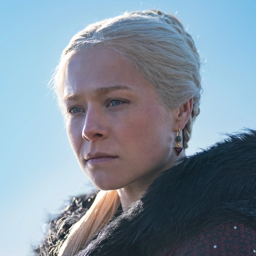

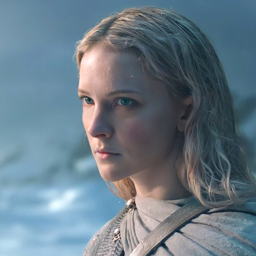

In [ ]:
#@title Input data (if you have no idea about prompt - use CLIP Interrogator)
start_image_link = 'https://i.imgur.com/FVhUxbm.png' #@param {type:"string"}
end_image_link = 'https://i.imgur.com/HEqWg6t.jpg' #@param {type:"string"}
links = [start_image_link, end_image_link]

autogenerate_prompts = False

start_image_prompt = 'a photo of close up face portrait of a woman' #@param {type:"string"}
end_image_prompt = 'a photo of close up face portrait of a young woman' #@param {type:"string"}
prompts = [start_image_prompt, end_image_prompt]

frames_path = '/content/png2png/' + str(uuid.uuid4())

images = prepare_images(frames_path, links, prompts, autogenerate_prompts)

In [ ]:
#@title Restore noise

noises = None
noise_restore_steps = 100 #@param {type:"integer"}
noise_restore_prompt_strength = 1 #@param {type:"slider", min:-1, max:1, step:0.1}

noises = finetune_noises(model, images, prompts, noise_restore_steps, noise_restore_prompt_strength)

  0%|          | 0/40 [00:00<?, ?it/s]

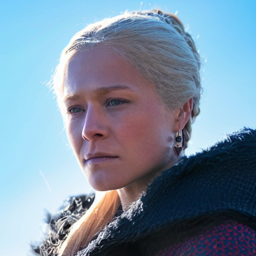

  0%|          | 0/40 [00:00<?, ?it/s]

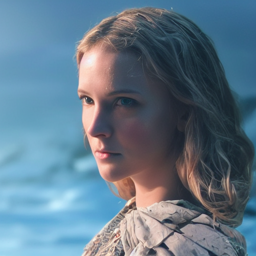

In [ ]:
#@title Finetune restoration

steps = 40 #@param {type:"integer"}

prompt_strength = 0.9 #@param {type:"slider", min:0, max:30, step:0.1}

initial_text_conds = showcase_noises(noises, prompts, steps, prompt_strength)

In [ ]:
#@title Generate video
length = 150 #@param {type:"integer"}
max_strength = 1.5 #@param {type:"slider", min:-1, max:24, step:0.1}
video_path = morph(start_image_prompt, end_image_prompt, noises[0], noises[1], length = length, prompt_strength=prompt_strength, max_strength=max_strength, frames_path=frames_path, num_steps = 30)

In [ ]:
#@title Show video
visualize_video_colab(video_path)